In [1]:
import matplotlib.pyplot as plt
import tools.dataTools as dt
from constants import Constants
import figure_params
import os
import matplotlib.pyplot as plt
import pyaldata as pyal
import pickle
from tqdm.auto import tqdm
from textwrap import wrap
import numpy as np
from scipy.linalg import orth, null_space
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import cm
import seaborn as sns
from tools.test import test_model

figure_params.set_rc_params
figure_params.setup_directories()

SUBFIG_DIR = Constants.FIG_FOLDER + 'figS4_noise/'
if not os.path.exists(SUBFIG_DIR):
    os.makedirs(SUBFIG_DIR)

# #run simulations for figure, will take a while to run
# import subprocess
# os.chdir(Constants.PROJ_DIR)
# subprocess.run(["bash", "simulation/fig_simulations/Sfig_synthetic_sims.sh"]) #uncomment code to make datasets if not made yet

import warnings
warnings.filterwarnings("ignore")

In [2]:
seeds = Constants.SEEDS
repertoires  = Constants.UNIS
reps = repertoires
dataset = '_synth_fixed_rad'
sim_set = 'uni_synth_fixed_rad'
seed_ex = Constants.SEED_EX
idx_go_cue = 282

#### Calculate comparison measures

In [3]:
datafile = 'uni_10.0_synth_fixed_rad'
redo = True
fname = Constants.PROCESSED_DATA_FOLDER + sim_set + \
    '/' + 'repertoire_comparison_measures_noise.pickle'
if os.path.isfile(fname) & (not redo):
    with open(fname, 'rb') as f:
        measures_df = pickle.load(f)
else:
    # calculate variance for unit activity, latent activity, position, and angle
    rows_list = []
    for seed in tqdm(seeds):
        for repertoire in repertoires:
            for noise in ([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):

                # get directories and model output
                outdir = dt.get_outdir(seed, sim_set, repertoire)
                datadir, _, output, _ = test_model(
                    outdir, noise=noise, datafile=datafile)

                # get data
                datname = Constants.PROJ_DIR + datadir
                test_data = np.load(datname+'.npy', allow_pickle=True).item()['test_set1']
                target = test_data['target']

                exec_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun=Constants.exec_epoch,
                                          subtract_mean=False, datafile=datafile, noise = noise)
                exec_df = dt.perform_pca(exec_df, Constants.PCA_DIMS)
                prep_exec_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun=Constants.prep_exec_epoch,
                                               subtract_mean=False, datafile=datafile, noise = noise) 
                prep_exec_df = dt.perform_pca(prep_exec_df, Constants.PCA_DIMS)

                # calculate mse
                mse_x = ((target[:, 50:, 0] - output[:, 50:, 0])**2).mean(axis=1)
                mse_y = ((target[:, 50:, 1] - output[:, 50:, 1])**2).mean(axis=1)
                mse_x = mse_x.mean()
                mse_y = mse_y.mean()

                mse_tstep = ((target[:, 50:, :] - output[:, 50:, :])**2).mean(axis=0)
                mse = mse_tstep.mean()

                # get output
                output = output[:, 50:, :]

                # calculate tangling
                X_pos = np.array(exec_df.pos.tolist())
                X_pos = np.transpose(X_pos, [0,2,1])
                tangling_pos = dt.tangling(X_pos)

                X_pca = np.array(prep_exec_df.both_pca.tolist())
                X_pca = np.transpose(X_pca, [0,2,1])
                tangling_pca = dt.tangling(X_pca)

                temp = {
                    'seed': seed,
                    'repertoire': repertoire,
                    'mse': mse,
                    'mse_x': mse_x,
                    'mse_y': mse_y,
                    'noise': noise,
                    'output': output,
                    'tangling_pos': tangling_pos,
                    'tangling_pca': tangling_pca,
                }
                rows_list.append(temp)

    measures_df = pd.DataFrame(rows_list)
    with open(fname, 'wb') as f:
        pickle.dump(measures_df, f)

measures_df['var_pos'] = [np.var(v, axis = 0) for v in measures_df.output.values]
measures_df.head()

measures_df['var_pos_flat'] = measures_df.apply(lambda x: x.var_pos.flatten(), axis = 1)
measures_df['var_pos_x'] = measures_df.apply(lambda x: x.var_pos[:,0].flatten(), axis = 1)
measures_df['var_pos_y'] = measures_df.apply(lambda x: x.var_pos[:,1].flatten(), axis = 1)

measures_df['var_pos_median'] = [np.median(v) for v in measures_df.var_pos_flat.values]
measures_df['var_pos_x_median'] = [np.median(v) for v in measures_df.var_pos_x.values]
measures_df['var_pos_y_median'] = [np.median(v) for v in measures_df.var_pos_y.values]


  0%|          | 0/10 [00:00<?, ?it/s]

### Latents change with noise

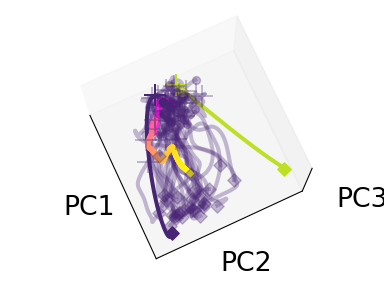

In [4]:
%matplotlib widget
sim_set = 'uni_rad'
datafile = 'uni_10.0_synth_fixed_rad'
noise = 1.0
repertoire = Constants.UNIS[1]
seed = Constants.SEEDS[3]

#get simulation data
df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.prep_exec_epoch, subtract_mean=False)
df_single = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.prep_exec_epoch, subtract_mean=False, noise=noise, datafile = datafile)

model = pyal.fit_dim_reduce_model(df, PCA(Constants.PCA_DIMS), 'MCx_rates')
df = pyal.apply_dim_reduce_model(df, model, 'MCx_rates', 'both_pca')
df = pyal.trial_average(df, 'target_param')
df_single = pyal.apply_dim_reduce_model(df_single, model, 'MCx_rates', 'both_pca')

#plot data
g = dt.plot_3d(df, 'both_pca', rel_start=int(Constants.WINDOW_prep[0]/Constants.BIN_SIZE))
g = dt.plot_3d(df_single.iloc[:30], 'both_pca', ax = g, alpha = 0.3, azim = -25, elev = 78, rel_start=int(Constants.WINDOW_prep[0]/Constants.BIN_SIZE))

pca = df_single.iloc[11].both_pca
for i in range(pca.shape[0]-1):
    g.plot(pca[i:i+2,0], pca[i:i+2,1], pca[i:i+2,2], color=plt.cm.spring(i/pca.shape[0]), linewidth = 4)

#remove ticks
g.set_xticks([])
g.set_yticks([])
g.set_zticks([])

params = '_'.join([sim_set, str(seed), repertoire, str(noise)])
plt.savefig(SUBFIG_DIR + f'latents_with_noise_{params}.pdf', format = 'pdf')



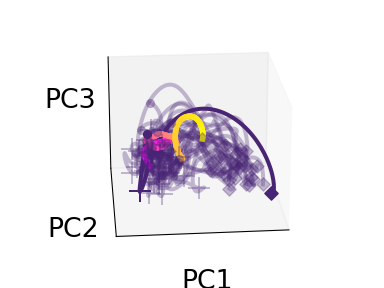

In [5]:
%matplotlib widget
sim_set = 'uni_rad'
datafile = 'uni_10.0_synth_fixed_rad'
noise = 1.0
repertoire = Constants.UNIS[0]
seed = Constants.SEEDS[3]

#get simulation data
df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.prep_exec_epoch, subtract_mean=False)
df_single = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.prep_exec_epoch, subtract_mean=False, noise=noise, datafile = datafile)

model = pyal.fit_dim_reduce_model(df, PCA(Constants.PCA_DIMS), 'MCx_rates')
df = pyal.apply_dim_reduce_model(df, model, 'MCx_rates', 'both_pca')
df = pyal.trial_average(df, 'target_param')
df_single = pyal.apply_dim_reduce_model(df_single, model, 'MCx_rates', 'both_pca')

#plot data
g = dt.plot_3d(df, 'both_pca', rel_start=int(Constants.WINDOW_prep[0]/Constants.BIN_SIZE))
dt.plot_3d(df_single.iloc[:30], 'both_pca', ax = g, alpha = 0.3, azim = -95, elev = 22, rel_start=int(Constants.WINDOW_prep[0]/Constants.BIN_SIZE))
pca = df_single.iloc[11].both_pca
for i in range(pca.shape[0]-1):
    g.plot(pca[i:i+2,0], pca[i:i+2,1], pca[i:i+2,2], color=plt.cm.spring(i/pca.shape[0]), linewidth = 4)
#remove ticks
g.set_xticks([])
g.set_yticks([])
g.set_zticks([])

params = '_'.join([sim_set, str(seed), repertoire, str(noise)])
plt.savefig(SUBFIG_DIR + f'latents_with_noise_{params}.pdf', format = 'pdf')




### Output change with noise


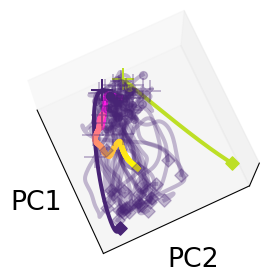

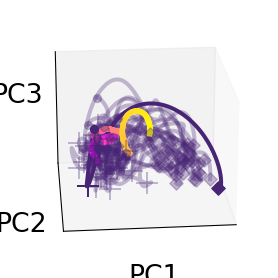

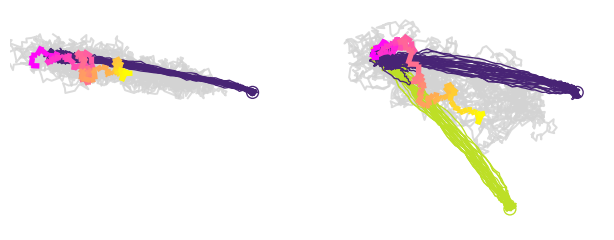

In [6]:
%matplotlib inline
from matplotlib.collections import LineCollection
cmap = dt.get_colormap(np.unique(measures_df.repertoire.values))
color_range = {'vmin': 0, 'vmax': 10}

dataset = '_synth_fixed_rad'

fix, axs = plt.subplots(ncols = 2, figsize = (8,3))
for i, rep in enumerate([reps[0], reps[1]]):

    df = measures_df[(measures_df.noise == 1.0) & (measures_df.repertoire == rep) & (measures_df.seed == seeds[3])]
    # dt.graph_repertoire(dataset, rep, ax = axs[i])
    
    pos = df.output.values[0]

    for trial in range(30):
        pos_ = pos[trial,idx_go_cue-50:]
        axs[i].plot(pos_[:,0], pos_[:,1], color = 'lightgrey', alpha = 0.8)
    dt.graph_output(seeds[3], sim_set, rep, ax = axs[i], graph_ntrials=30)

    
    trial = 11
    pos_ = pos[trial,idx_go_cue-50:]

    points = np.expand_dims(pos_[:,:],1)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cols = np.linspace(0,1,points.shape[0])
    lc = LineCollection(segments, cmap='spring', alpha=1)
    lc.set_array(cols)
    lc.set_linewidth(4)
    line = axs[i].add_collection(lc)
    plt.setp(line, zorder=20)
    
    axs[i].set_ylim(-7,2)
    axs[i].set_xlim(-2,9)
    axs[i].set_aspect(1)

plt.savefig(SUBFIG_DIR + 'example_noise_output.pdf', bbox_inches='tight')

### Tangling

In [7]:
measures_df['tangling_pos_90_perc'] = measures_df.tangling_pos.apply(lambda x: np.percentile(x, 90))
measures_df['tangling_pca_90_perc'] = measures_df.tangling_pca.apply(lambda x: np.percentile(x, 90))

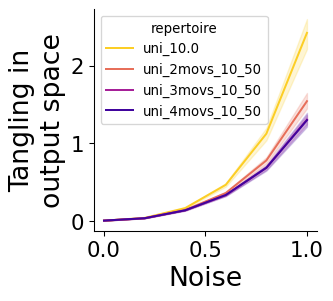

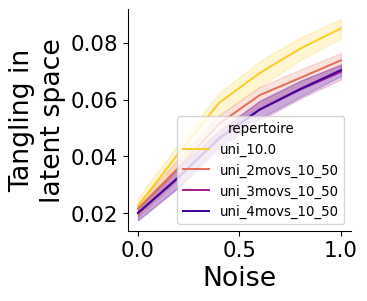

In [8]:
cmap = 'plasma_r'
colors = [cm.get_cmap(cmap)(i)for i in np.linspace(0.1, 0.9, len(repertoires))]

plt.figure(figsize=(3,3))
sns.lineplot(data = measures_df, x = 'noise', y = 'tangling_pos_90_perc', hue = 'repertoire', palette=colors)
plt.ylabel("\n".join(wrap('Tangling in output space', 15)))
plt.xlabel('Noise')
plt.savefig(SUBFIG_DIR + 'tangling_output_noise.pdf', format = 'pdf', bbox_inches='tight')

plt.figure(figsize=(3,3))
sns.lineplot(data = measures_df, x = 'noise', y = 'tangling_pca_90_perc', hue = 'repertoire', palette=colors)
plt.ylabel("\n".join(wrap('Tangling in latent space', 15)))
plt.xlabel('Noise')
plt.savefig(SUBFIG_DIR + 'tangling_latent_noise.pdf', format = 'pdf', bbox_inches='tight')

### Variance and MSE with noise

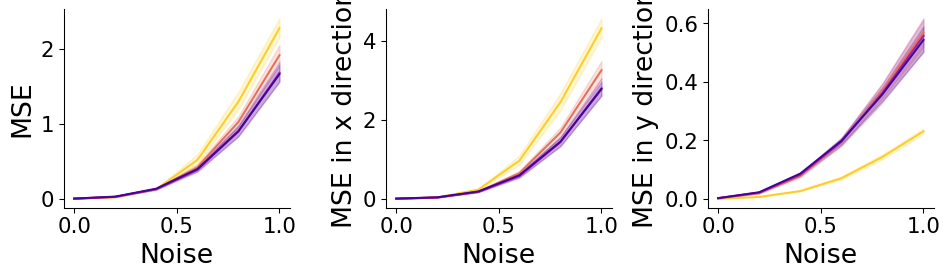

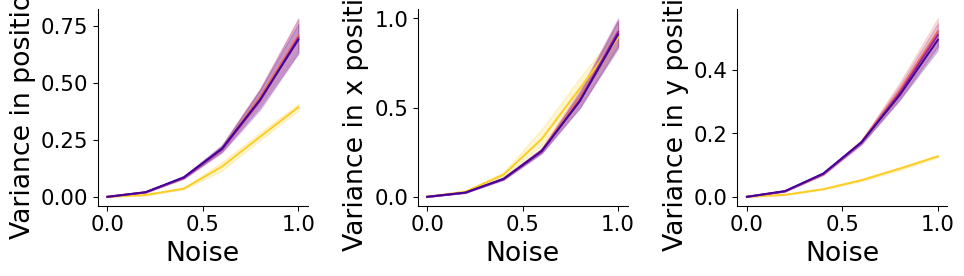

In [9]:
%matplotlib inline
measures_df.head()

cmap = 'plasma_r'
colors = [cm.get_cmap(cmap)(i)for i in np.linspace(0.1, 0.9, len(repertoires))]

#MSE with noise
fig, axs = plt.subplots(ncols = 3, figsize = (10,3))
sns.lineplot(data = measures_df, x = 'noise', y = 'mse', hue = 'repertoire', palette=colors, ax = axs[0])
axs[0].set_ylabel('MSE')
sns.lineplot(data = measures_df, x = 'noise', y = 'mse_x', hue = 'repertoire', palette=colors, ax = axs[1])
axs[1].set_ylabel('MSE in x direction')
sns.lineplot(data = measures_df, x = 'noise', y = 'mse_y', hue = 'repertoire', palette=colors, ax = axs[2])
axs[2].set_ylabel('MSE in y direction')
for ax in axs:
    #remove legend
    ax.get_legend().remove()
    ax.set_xlabel('Noise')
plt.tight_layout()
plt.savefig(SUBFIG_DIR + f'mse_{sim_set}.pdf', format = 'pdf')

#variance with noise
fig, axs = plt.subplots(ncols = 3, figsize = (10,3))
sns.lineplot(data = measures_df, x = 'noise', y = 'var_pos_median', hue = 'repertoire', palette=colors, ax = axs[0])
axs[0].set_ylabel('Variance in position')
sns.lineplot(data = measures_df, x = 'noise', y = 'var_pos_x_median', hue = 'repertoire', palette=colors, ax = axs[1])
axs[1].set_ylabel('Variance in x position')
sns.lineplot(data = measures_df, x = 'noise', y = 'var_pos_y_median', hue = 'repertoire', palette=colors, ax = axs[2])
axs[2].set_ylabel('Variance in y position')
for ax in axs:
    #remove legend
    ax.get_legend().remove()
    ax.set_xlabel('Noise')
plt.tight_layout()
plt.savefig(SUBFIG_DIR + f'variance_{sim_set}.pdf', format = 'pdf')
